In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import h5py
from tqdm import tqdm
from torch.amp import GradScaler, autocast

In [2]:
class DoubleConv(nn.Module):
    """
    A sequence of two 3x3 convolutions each followed by ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    A basic U-Net architecture without attention, SE blocks, or deep supervision.
    """
    def __init__(self, in_channels=1, out_channels=1, features=None):
        super(UNet, self).__init__()
        if features is None:
            features = [128, 256, 512, 1024]

        # Encoder path
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder path
        self.ups = nn.ModuleList()
        rev_features = features[::-1]
        for feature in rev_features:
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=3, stride=2))
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final 1x1 conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=3, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # ConvTranspose2d
            skip = skip_connections[idx // 2]
            # In case the inexact sizes due to pooling
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)  # DoubleConv

        return self.final_conv(x)


In [3]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num   = 2 * (probs * targets).sum(dim=(1,2,3))
        den   = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + self.eps
        dice  = num / den
        return 1 - dice.mean()

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bw = bce_weight

    def forward(self, logits, targets):
        return self.bw * self.bce(logits, targets) + (1 - self.bw) * self.dice(logits, targets)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.gamma, self.eps = alpha, gamma, eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(self.eps, 1 - self.eps)
        pt = torch.where(targets==1, probs, 1 - probs)
        w  = torch.where(targets==1, self.alpha, 1 - self.alpha)
        loss = - w * (1 - pt)**self.gamma * pt.log()
        return loss.mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.eps = alpha, beta, eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        TP = (probs * targets).sum(dim=(1,2,3))
        FP = (probs * (1-targets)).sum(dim=(1,2,3))
        FN = ((1-probs) * targets).sum(dim=(1,2,3))
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return 1 - tversky.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=1.5, eps=1e-6):
        super().__init__()
        self.tversky = TverskyLoss(alpha, beta, eps)
        self.gamma = gamma

    def forward(self, logits, targets):
        t = 1 - self.tversky(logits, targets)
        return t ** self.gamma

class TverskyF2Loss(nn.Module):
    def forward(self, preds, targets):
        TP = (preds*targets).sum()
        FN = ((1-preds)*targets).sum()
        FP = (preds*(1-targets)).sum()
        return (FN + 1e-6) / (2*TP + FN + 1e-6)

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.eps = alpha, beta, gamma, eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.4):
        super().__init__()
        self.bce  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.ft   = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=2.0)
        self.tf2 = TverskyF2Loss()
        self.bw, self.dw= bce_weight, dice_weight
    def forward(self, logits, targets):
        bce_loss  = self.bce(logits, targets)
        dice_loss = self.ft(torch.sigmoid(logits), targets)
        return self.bw*bce_loss + self.dw*dice_loss

class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None:
            self.f = h5py.File(self.path,'r', swmr=True)
        x = torch.from_numpy(self.f['x'][idx]).float()
        y = torch.from_numpy(self.f['y'][idx]).float()
        return x, y

In [ ]:
if __name__ == '__main__':
    bs, max_batches, epochs = 64, 500, 400
    train_path = 'train.h5'
    val_path   = 'val.h5'

    # ─── datasets ───
    train_ds = H5Dataset(train_path)
    val_ds   = H5Dataset(val_path)

    # ─── train loader ───
    # pick exactly bs*max_batches random samples from train set
    tr_idx = torch.randperm(len(train_ds))[: bs * max_batches]
    tr_loader = DataLoader(
        train_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(tr_idx),
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )

    # ─── val loader ───
    # just iterate through val.h5 in order (or set shuffle=True if you like)
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        shuffle=False,
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet(in_channels=1, out_channels=1).to(device)
    crit  = ComboLoss(pos_weight=500, bce_weight=0.5, dice_weight=0.5)

    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-4, steps_per_epoch=len(tr_loader), epochs=epochs)

    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    train_losses = []
    val_losses = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(1, epochs+1):
        # ——— train ———
        model.train()
        total_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar:=tqdm(tr_loader, desc=f"Epoch {epoch}")):
            imgs = imgs/50
            imgs = imgs.to(device)
            msk  = msk.to(device)
            opt.zero_grad()
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                seg_logits = model(imgs)
                loss = crit(seg_logits, msk)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix(avg_train_loss=total_loss/(bs*(batch_num+1)), batch_loss=loss.item()/bs, lr=sched.get_last_lr()[0])
            sched.step()
        train_losses.append(total_loss/len(train_ds))

        # ——— validate ———
        model.eval()
        with torch.no_grad():
            tp=fp=fn=0
            loss = 0
            for imgs, msk in val_loader:
                imgs = imgs/50
                imgs = imgs.to(device)
                msk  = msk.to(device)
                with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                    seg_logits = model(imgs)
                    loss += crit(seg_logits, msk)
                preds = (torch.sigmoid(seg_logits)>0.5).float().view(-1)
                t     = msk.view(-1)

                tp += (preds * t).sum().item()
                fp += (preds * (1-t)).sum().item()
                fn += ((1-preds)*t).sum().item()

            prec = tp/(tp+fp+1e-8)
            rec  = tp/(tp+fn+1e-8)
            f1   = 2*prec*rec/(prec+rec+1e-8)
            val_losses.append(loss/len(val_ds))
            val_f1s.append(f1)
            val_precisions.append(prec)
            val_recalls.append(rec)
            print(f"Val loss: {loss/len(val_ds):.4f}  Val F1: {f1:.4f}  (P={prec:.4f}, R={rec:.4f})")

Epoch 1: 100%|██████████| 235/235 [01:11<00:00,  3.30it/s, avg_train_loss=0.0175, batch_loss=0.0154, lr=4.02e-6]


Val loss: 0.0139  Val F1: 0.0005  (P=0.0003, R=0.7252)


Epoch 2: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0167, batch_loss=0.0166, lr=4.07e-6]


Val loss: 0.0131  Val F1: 0.0007  (P=0.0003, R=0.6203)


Epoch 3: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0164, batch_loss=0.016, lr=4.15e-6] 


Val loss: 0.0127  Val F1: 0.0007  (P=0.0004, R=0.5893)


Epoch 4: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0157, batch_loss=0.0151, lr=4.26e-6]


Val loss: 0.0122  Val F1: 0.0008  (P=0.0004, R=0.5358)


Epoch 5: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0139, batch_loss=0.0134, lr=4.41e-6]


Val loss: 0.0120  Val F1: 0.0008  (P=0.0004, R=0.4750)


Epoch 6: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0124, batch_loss=0.0126, lr=4.59e-6]


Val loss: 0.0126  Val F1: 0.0007  (P=0.0003, R=0.4857)


Epoch 7: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.0115, batch_loss=0.0122, lr=4.8e-6] 


Val loss: 0.0112  Val F1: 0.0013  (P=0.0006, R=0.3391)


Epoch 8: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0109, batch_loss=0.0116, lr=5.05e-6]


Val loss: 0.0114  Val F1: 0.0011  (P=0.0006, R=0.3492)


Epoch 9: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.0105, batch_loss=0.0106, lr=5.33e-6]


Val loss: 0.0106  Val F1: 0.0019  (P=0.0010, R=0.2285)


Epoch 10: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0102, batch_loss=0.0123, lr=5.63e-6] 


Val loss: 0.0109  Val F1: 0.0012  (P=0.0006, R=0.2636)


Epoch 11: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.0101, batch_loss=0.00983, lr=5.98e-6]


Val loss: 0.0111  Val F1: 0.0010  (P=0.0005, R=0.2934)


Epoch 12: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.00982, batch_loss=0.00975, lr=6.35e-6]


Val loss: 0.0103  Val F1: 0.0029  (P=0.0014, R=0.2507)


Epoch 13: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00949, batch_loss=0.00953, lr=6.75e-6]


Val loss: 0.0103  Val F1: 0.0026  (P=0.0013, R=0.2308)


Epoch 14: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.0094, batch_loss=0.00932, lr=7.19e-6] 


Val loss: 0.0102  Val F1: 0.0029  (P=0.0014, R=0.2162)


Epoch 15: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00939, batch_loss=0.0104, lr=7.65e-6] 


Val loss: 0.0105  Val F1: 0.0016  (P=0.0008, R=0.2583)


Epoch 16: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00928, batch_loss=0.00937, lr=8.15e-6]


Val loss: 0.0103  Val F1: 0.0020  (P=0.0010, R=0.2322)


Epoch 17: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00903, batch_loss=0.00909, lr=8.67e-6]


Val loss: 0.0100  Val F1: 0.0031  (P=0.0016, R=0.2157)


Epoch 18: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00873, batch_loss=0.01, lr=9.23e-6]   


Val loss: 0.0101  Val F1: 0.0024  (P=0.0012, R=0.1666)


Epoch 19: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00896, batch_loss=0.00916, lr=9.81e-6]


Val loss: 0.0100  Val F1: 0.0030  (P=0.0015, R=0.2179)


Epoch 20: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00902, batch_loss=0.00894, lr=1.04e-5]


Val loss: 0.0100  Val F1: 0.0026  (P=0.0013, R=0.2840)


Epoch 21: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.0087, batch_loss=0.00847, lr=1.11e-5] 


Val loss: 0.0099  Val F1: 0.0029  (P=0.0015, R=0.2511)


Epoch 22: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00834, batch_loss=0.00826, lr=1.17e-5]


Val loss: 0.0098  Val F1: 0.0037  (P=0.0019, R=0.2301)


Epoch 23: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00804, batch_loss=0.0081, lr=1.24e-5] 


Val loss: 0.0099  Val F1: 0.0028  (P=0.0014, R=0.1866)


Epoch 24: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00828, batch_loss=0.00842, lr=1.32e-5]


Val loss: 0.0104  Val F1: 0.0014  (P=0.0007, R=0.2876)


Epoch 25: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00841, batch_loss=0.00794, lr=1.39e-5]


Val loss: 0.0098  Val F1: 0.0032  (P=0.0016, R=0.1959)


Epoch 26: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00805, batch_loss=0.00766, lr=1.47e-5]


Val loss: 0.0098  Val F1: 0.0031  (P=0.0015, R=0.2071)


Epoch 27: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00799, batch_loss=0.00729, lr=1.55e-5]


Val loss: 0.0098  Val F1: 0.0040  (P=0.0020, R=0.2153)


Epoch 28: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00782, batch_loss=0.00689, lr=1.63e-5]


Val loss: 0.0098  Val F1: 0.0032  (P=0.0016, R=0.2425)


Epoch 29: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00771, batch_loss=0.00773, lr=1.72e-5]


Val loss: 0.0101  Val F1: 0.0020  (P=0.0010, R=0.2190)


Epoch 30: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00746, batch_loss=0.00677, lr=1.81e-5]


Val loss: 0.0100  Val F1: 0.0035  (P=0.0017, R=0.1882)


Epoch 31: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00719, batch_loss=0.00664, lr=1.9e-5] 


Val loss: 0.0099  Val F1: 0.0051  (P=0.0026, R=0.1674)


Epoch 32: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00724, batch_loss=0.00662, lr=1.99e-5]


Val loss: 0.0099  Val F1: 0.0044  (P=0.0022, R=0.2327)


Epoch 33: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00702, batch_loss=0.0111, lr=2.08e-5] 


Val loss: 0.0100  Val F1: 0.0034  (P=0.0017, R=0.1730)


Epoch 34: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00662, batch_loss=0.00731, lr=2.18e-5]


Val loss: 0.0104  Val F1: 0.0019  (P=0.0009, R=0.2333)


Epoch 35: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00661, batch_loss=0.00703, lr=2.28e-5]


Val loss: 0.0101  Val F1: 0.0034  (P=0.0017, R=0.2155)


Epoch 36: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00606, batch_loss=0.00696, lr=2.38e-5]


Val loss: 0.0102  Val F1: 0.0047  (P=0.0024, R=0.1819)


Epoch 37: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00551, batch_loss=0.0047, lr=2.48e-5] 


Val loss: 0.0102  Val F1: 0.0054  (P=0.0028, R=0.1673)


Epoch 38: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00542, batch_loss=0.0054, lr=2.59e-5] 


Val loss: 0.0103  Val F1: 0.0066  (P=0.0034, R=0.1666)


Epoch 39: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00522, batch_loss=0.00407, lr=2.69e-5]


Val loss: 0.0104  Val F1: 0.0049  (P=0.0025, R=0.1751)


Epoch 40: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00488, batch_loss=0.0066, lr=2.8e-5]  


Val loss: 0.0106  Val F1: 0.0030  (P=0.0015, R=0.1919)


Epoch 41: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00459, batch_loss=0.00503, lr=2.91e-5]


Val loss: 0.0105  Val F1: 0.0100  (P=0.0052, R=0.1532)


Epoch 42: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00426, batch_loss=0.00319, lr=3.02e-5]


Val loss: 0.0106  Val F1: 0.0045  (P=0.0023, R=0.1933)


Epoch 43: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00462, batch_loss=0.00426, lr=3.13e-5]


Val loss: 0.0106  Val F1: 0.0046  (P=0.0023, R=0.2028)


Epoch 44: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00399, batch_loss=0.00782, lr=3.25e-5]


Val loss: 0.0106  Val F1: 0.0083  (P=0.0043, R=0.1992)


Epoch 45: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00427, batch_loss=0.00531, lr=3.36e-5]


Val loss: 0.0108  Val F1: 0.0141  (P=0.0074, R=0.1537)


Epoch 46: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00417, batch_loss=0.00527, lr=3.48e-5]


Val loss: 0.0108  Val F1: 0.0092  (P=0.0047, R=0.1645)


Epoch 47: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00383, batch_loss=0.00375, lr=3.6e-5] 


Val loss: 0.0109  Val F1: 0.0070  (P=0.0036, R=0.1907)


Epoch 48: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00315, batch_loss=0.00337, lr=3.72e-5]


Val loss: 0.0112  Val F1: 0.0089  (P=0.0046, R=0.1287)


Epoch 49: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00296, batch_loss=0.00276, lr=3.84e-5]


Val loss: 0.0110  Val F1: 0.0213  (P=0.0116, R=0.1275)


Epoch 50: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00275, batch_loss=0.0036, lr=3.96e-5] 


Val loss: 0.0110  Val F1: 0.0289  (P=0.0162, R=0.1345)


Epoch 51: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00406, batch_loss=0.0156, lr=4.08e-5] 


Val loss: 0.0111  Val F1: 0.0086  (P=0.0044, R=0.1351)


Epoch 52: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.0044, batch_loss=0.0076, lr=4.2e-5]   


Val loss: 0.0111  Val F1: 0.0093  (P=0.0048, R=0.1536)


Epoch 53: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00428, batch_loss=0.00414, lr=4.32e-5]


Val loss: 0.0111  Val F1: 0.0166  (P=0.0087, R=0.1648)


Epoch 54: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00378, batch_loss=0.0051, lr=4.45e-5] 


Val loss: 0.0112  Val F1: 0.0166  (P=0.0087, R=0.1572)


Epoch 55: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00347, batch_loss=0.00388, lr=4.57e-5]


Val loss: 0.0114  Val F1: 0.0091  (P=0.0047, R=0.1500)


Epoch 56: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.0029, batch_loss=0.00353, lr=4.7e-5]  


Val loss: 0.0114  Val F1: 0.0190  (P=0.0102, R=0.1516)


Epoch 57: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00236, batch_loss=0.00202, lr=4.82e-5]


Val loss: 0.0112  Val F1: 0.0170  (P=0.0089, R=0.1859)


Epoch 58: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00337, batch_loss=0.00324, lr=4.95e-5]


Val loss: 0.0112  Val F1: 0.0135  (P=0.0070, R=0.1813)


Epoch 59: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00439, batch_loss=0.00421, lr=5.07e-5]


Val loss: 0.0113  Val F1: 0.0122  (P=0.0063, R=0.1816)


Epoch 60: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00394, batch_loss=0.0111, lr=5.2e-5]  


Val loss: 0.0115  Val F1: 0.0236  (P=0.0129, R=0.1431)


Epoch 61: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00361, batch_loss=0.00689, lr=5.33e-5]


Val loss: 0.0115  Val F1: 0.0181  (P=0.0097, R=0.1345)


Epoch 62: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00319, batch_loss=0.00544, lr=5.45e-5]


Val loss: 0.0113  Val F1: 0.0092  (P=0.0047, R=0.1788)


Epoch 63: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00319, batch_loss=0.00325, lr=5.58e-5]


Val loss: 0.0115  Val F1: 0.0252  (P=0.0139, R=0.1357)


Epoch 64: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00215, batch_loss=0.00482, lr=5.7e-5] 


Val loss: 0.0114  Val F1: 0.0317  (P=0.0177, R=0.1510)


Epoch 65: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00231, batch_loss=0.00189, lr=5.83e-5]


Val loss: 0.0116  Val F1: 0.0115  (P=0.0060, R=0.1709)


Epoch 66: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00338, batch_loss=0.00324, lr=5.95e-5]


Val loss: 0.0117  Val F1: 0.0213  (P=0.0115, R=0.1520)


Epoch 67: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00387, batch_loss=0.00451, lr=6.07e-5]


Val loss: 0.0118  Val F1: 0.0071  (P=0.0036, R=0.1415)


Epoch 68: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00394, batch_loss=0.00406, lr=6.2e-5] 


Val loss: 0.0118  Val F1: 0.0108  (P=0.0056, R=0.1597)


Epoch 69: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00352, batch_loss=0.00497, lr=6.32e-5]


Val loss: 0.0117  Val F1: 0.0270  (P=0.0150, R=0.1340)


Epoch 70: 100%|██████████| 235/235 [01:09<00:00,  3.37it/s, avg_train_loss=0.00311, batch_loss=0.00296, lr=6.44e-5]


Val loss: 0.0118  Val F1: 0.0117  (P=0.0061, R=0.1502)


Epoch 71: 100%|██████████| 235/235 [01:11<00:00,  3.30it/s, avg_train_loss=0.00226, batch_loss=0.000998, lr=6.56e-5]


Val loss: 0.0116  Val F1: 0.0314  (P=0.0177, R=0.1393)


Epoch 72: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.00256, batch_loss=0.00751, lr=6.68e-5]


Val loss: 0.0117  Val F1: 0.0311  (P=0.0174, R=0.1493)


Epoch 73: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.00266, batch_loss=0.00242, lr=6.8e-5] 


Val loss: 0.0120  Val F1: 0.0166  (P=0.0088, R=0.1401)


Epoch 74: 100%|██████████| 235/235 [01:13<00:00,  3.21it/s, avg_train_loss=0.00317, batch_loss=0.00374, lr=6.92e-5]


Val loss: 0.0118  Val F1: 0.0155  (P=0.0082, R=0.1466)


Epoch 75: 100%|██████████| 235/235 [01:10<00:00,  3.32it/s, avg_train_loss=0.00347, batch_loss=0.00817, lr=7.04e-5]


Val loss: 0.0117  Val F1: 0.0131  (P=0.0068, R=0.1714)


Epoch 76: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.00449, batch_loss=0.00396, lr=7.15e-5]


Val loss: 0.0118  Val F1: 0.0143  (P=0.0075, R=0.1504)


Epoch 77: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.00294, batch_loss=0.0068, lr=7.27e-5] 


Val loss: 0.0120  Val F1: 0.0096  (P=0.0050, R=0.1485)


Epoch 78: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, avg_train_loss=0.00321, batch_loss=0.00784, lr=7.38e-5]


Val loss: 0.0119  Val F1: 0.0172  (P=0.0091, R=0.1789)


Epoch 79: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, avg_train_loss=0.00258, batch_loss=0.00188, lr=7.49e-5]


Val loss: 0.0122  Val F1: 0.0143  (P=0.0076, R=0.1355)


Epoch 80: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.00211, batch_loss=0.00173, lr=7.6e-5] 


Val loss: 0.0121  Val F1: 0.0243  (P=0.0133, R=0.1460)


Epoch 81: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.00205, batch_loss=0.00197, lr=7.71e-5]


Val loss: 0.0120  Val F1: 0.0262  (P=0.0142, R=0.1707)


Epoch 82: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, avg_train_loss=0.00199, batch_loss=0.00226, lr=7.81e-5]


Val loss: 0.0122  Val F1: 0.0232  (P=0.0125, R=0.1682)


Epoch 83: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, avg_train_loss=0.00275, batch_loss=0.00336, lr=7.92e-5]


Val loss: 0.0123  Val F1: 0.0171  (P=0.0091, R=0.1383)


Epoch 84: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, avg_train_loss=0.00327, batch_loss=0.00219, lr=8.02e-5]


Val loss: 0.0118  Val F1: 0.0144  (P=0.0075, R=0.1824)


Epoch 85: 100%|██████████| 235/235 [01:10<00:00,  3.31it/s, avg_train_loss=0.00318, batch_loss=0.00386, lr=8.12e-5]


Val loss: 0.0121  Val F1: 0.0147  (P=0.0077, R=0.1635)


Epoch 86: 100%|██████████| 235/235 [01:10<00:00,  3.33it/s, avg_train_loss=0.00338, batch_loss=0.00286, lr=8.22e-5]


Val loss: 0.0120  Val F1: 0.0155  (P=0.0081, R=0.1627)


Epoch 87: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00277, batch_loss=0.0022, lr=8.32e-5] 


Val loss: 0.0122  Val F1: 0.0148  (P=0.0077, R=0.1695)


Epoch 88: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00244, batch_loss=0.0019, lr=8.41e-5] 


Val loss: 0.0123  Val F1: 0.0164  (P=0.0086, R=0.1699)


Epoch 89: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00235, batch_loss=0.00472, lr=8.5e-5] 


Val loss: 0.0126  Val F1: 0.0121  (P=0.0063, R=0.1285)


Epoch 90: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00227, batch_loss=0.00412, lr=8.59e-5]


Val loss: 0.0123  Val F1: 0.0301  (P=0.0168, R=0.1476)


Epoch 91: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00184, batch_loss=0.00214, lr=8.68e-5]


Val loss: 0.0123  Val F1: 0.0135  (P=0.0070, R=0.1709)


Epoch 92: 100%|██████████| 235/235 [01:10<00:00,  3.36it/s, avg_train_loss=0.00227, batch_loss=0.00383, lr=8.77e-5]


Val loss: 0.0122  Val F1: 0.0298  (P=0.0164, R=0.1591)


Epoch 93: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00334, batch_loss=0.0046, lr=8.85e-5] 


Val loss: 0.0125  Val F1: 0.0236  (P=0.0128, R=0.1528)


Epoch 94: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00293, batch_loss=0.00213, lr=8.93e-5]


Val loss: 0.0122  Val F1: 0.0319  (P=0.0179, R=0.1457)


Epoch 95: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.0027, batch_loss=0.00209, lr=9.01e-5] 


Val loss: 0.0125  Val F1: 0.0275  (P=0.0153, R=0.1323)


Epoch 96: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00192, batch_loss=0.00115, lr=9.08e-5]


Val loss: 0.0122  Val F1: 0.0328  (P=0.0186, R=0.1390)


Epoch 97: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00174, batch_loss=0.0015, lr=9.16e-5] 


Val loss: 0.0126  Val F1: 0.0253  (P=0.0139, R=0.1409)


Epoch 98: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00216, batch_loss=0.00374, lr=9.23e-5]


Val loss: 0.0125  Val F1: 0.0439  (P=0.0261, R=0.1399)


Epoch 99: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00227, batch_loss=0.00482, lr=9.29e-5]


Val loss: 0.0127  Val F1: 0.0240  (P=0.0129, R=0.1684)


Epoch 100: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00202, batch_loss=0.00512, lr=9.36e-5]


Val loss: 0.0125  Val F1: 0.0189  (P=0.0101, R=0.1470)


Epoch 101: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00221, batch_loss=0.00217, lr=9.42e-5] 


Val loss: 0.0125  Val F1: 0.0269  (P=0.0146, R=0.1646)


Epoch 102: 100%|██████████| 235/235 [01:10<00:00,  3.35it/s, avg_train_loss=0.00299, batch_loss=0.00286, lr=9.48e-5]


Val loss: 0.0127  Val F1: 0.0252  (P=0.0138, R=0.1430)


Epoch 103: 100%|██████████| 235/235 [01:11<00:00,  3.28it/s, avg_train_loss=0.00241, batch_loss=0.00418, lr=9.53e-5]


Val loss: 0.0125  Val F1: 0.0319  (P=0.0179, R=0.1494)


Epoch 104: 100%|██████████| 235/235 [01:15<00:00,  3.13it/s, avg_train_loss=0.00208, batch_loss=0.00265, lr=9.58e-5] 


Val loss: 0.0129  Val F1: 0.0236  (P=0.0130, R=0.1301)


Epoch 105: 100%|██████████| 235/235 [01:13<00:00,  3.19it/s, avg_train_loss=0.00195, batch_loss=0.0029, lr=9.63e-5]  


Val loss: 0.0127  Val F1: 0.0436  (P=0.0259, R=0.1372)


Epoch 106:  14%|█▍        | 34/235 [00:10<01:00,  3.34it/s, avg_train_loss=0.0021, batch_loss=0.00334, lr=9.64e-5] 

In [9]:
torch.save(model.state_dict(), "unet_basic.pth")

15000

In [132]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.eps = alpha, beta, gamma, eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.4):
        super().__init__()
        self.bce  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.ft   = FocalTverskyLoss(alpha=0.8, beta=0.2, gamma=0.3)
        self.bw, self.dw= bce_weight, dice_weight
    def forward(self, logits, targets):
        bce_loss  = self.bce(logits, targets)
        dice_loss = self.ft(torch.sigmoid(logits), targets)
        return self.bw*bce_loss + self.dw*dice_loss

class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None:
            self.f = h5py.File(self.path,'r', swmr=True)
        x = torch.from_numpy(self.f['x'][idx]).float()
        y = torch.from_numpy(self.f['y'][idx]).float()
        return x, y

class DoubleConv(nn.Module):
    """
    A sequence of two 3x3 convolutions each followed by ReLU activation.
    """
    def __init__(self, in_channels, out_channels, activation):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            activation
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """
    A basic U-Net architecture without attention, SE blocks, or deep supervision.
    """
    def __init__(self, inshape=1, outshape=1, downfeatures=None, downactivation=None, bottleneckfeatures=None, upfeatures=None, upactivation=None):
        super(UNet, self).__init__()
        in_channels = 1
        out_channels = 1
        if downfeatures is None:
            downfeatures = [128, 256, 512, 1024]
        if bottleneckfeatures is None:
            bottleneckfeatures = downfeatures[-1] * 2
        if upfeatures is None:
            upfeatures = downfeatures[::-1]
        if downactivation is None:
            downactivation = [nn.ReLU(inplace=True) for _ in range(len(downfeatures))]
        else:
            downactivation = [get_activation(act) for act in downactivation]
        if upactivation is None:
            upactivation = downactivation[::-1]
        else:
            upactivation = [get_activation(act) for act in upactivation]

        # Encoder path
        self.downs = nn.ModuleList()
        for l, feature in enumerate(downfeatures):
            self.downs.append(DoubleConv(in_channels, feature, downactivation[l]))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(downfeatures[-1], bottleneckfeatures, nn.ReLU(inplace=True))

        # Decoder path
        self.ups = nn.ModuleList()
        in_channels = bottleneckfeatures
        for l, feature in enumerate(upfeatures):
            self.ups.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=3, stride=2, padding=1))
            self.ups.append(DoubleConv(in_channels, feature, upactivation[l]))
            in_channels = feature

        # Final 1x1 conv
        self.final_conv = nn.Conv2d(upfeatures[-1], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]

        # Upsampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # ConvTranspose2d
            skip = skip_connections[idx // 2]
            # In case the inexact sizes due to pooling
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)  # DoubleConv

        return self.final_conv(x)

def get_activation(name):
    """
    Get activation function by name.
    """
    activations = {
        'relu': nn.ReLU(inplace=True),
        'leaky_relu': nn.LeakyReLU(inplace=True),
        'elu': nn.ELU(inplace=True),
        'prelu': nn.PReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'softmax': nn.Softmax(dim=1),
    }
    return activations.get(name, None)

def train(model, train_ds, val_ds, loss=None, epochs=100):
    bs, max_batches = 64, 500
     # ─── train loader ───
    # pick exactly bs*max_batches random samples from train set
    tr_idx = torch.randperm(len(train_ds))[: bs * max_batches]
    output_size = get_model_output_size(model)


    tr_loader = DataLoader(
        train_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(tr_idx),
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )

    # ─── val loader ───
    # just iterate through val.h5 in order (or set shuffle=True if you like)
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        shuffle=False,
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    if loss is None:
        crit  = ComboLoss(pos_weight=500, bce_weight=0.5, dice_weight=0.5)
    else:
        crit = loss

    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-4, steps_per_epoch=len(tr_loader), epochs=epochs)

    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    train_losses = []
    val_losses = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(1, epochs+1):
        # ——— train ———
        model.train()
        total_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar:=tqdm(tr_loader, desc=f"Epoch {epoch}")):
            imgs = imgs/50
            imgs = imgs.to(device)
            msk = downsize_y(msk, output_size)
            msk  = msk.to(device)
            opt.zero_grad()
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                seg_logits = model(imgs)
                loss = crit(seg_logits, msk)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix(avg_train_loss=total_loss/(bs*(batch_num+1)), batch_loss=loss.item()/bs, lr=sched.get_last_lr()[0])
            sched.step()
        train_losses.append(total_loss/len(train_ds))

        # ——— validate ———
        model.eval()
        with torch.no_grad():
            tp=fp=fn=0
            loss = 0
            for imgs, msk in val_loader:
                imgs = imgs/50
                imgs = imgs.to(device)
                msk = downsize_y(msk, output_size)
                msk  = msk.to(device)
                with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                    seg_logits = model(imgs)
                    loss += crit(seg_logits, msk)
                preds = (torch.sigmoid(seg_logits)>0.5).float().view(-1)
                t     = msk.view(-1)

                tp += (preds * t).sum().item()
                fp += (preds * (1-t)).sum().item()
                fn += ((1-preds)*t).sum().item()

            prec = tp/(tp+fp+1e-8)
            rec  = tp/(tp+fn+1e-8)
            f1   = 2*prec*rec/(prec+rec+1e-8)
            val_losses.append(loss/len(val_ds))
            val_f1s.append(f1)
            val_precisions.append(prec)
            val_recalls.append(rec)
            print(f"Val loss: {loss/len(val_ds):.4f}  Val F1: {f1:.4f}  (P={prec:.4f}, R={rec:.4f})")

In [136]:
def downsize_y(y, size):
    """
    Downsize the y tensor to the given size.
    """
    if y.shape[-2:] == size:
        return y
    else:
        #downsized = F.interpolate(y, size=size, mode='bilinear', align_corners=True)
        downsized = F.interpolate(y, size=size, mode="area")
        # make downsized tensor only 0 or 1 by doing ceil
        downsized = torch.ceil(downsized)
        #downsized[downsized>0.2] = 1
        #downsized[downsized<=0.2] = 0
        return downsized

def get_model_output_size(model):
    """
    Get the output size of the model.
    """
    x = torch.randn(1, 1, 128, 128)
    x = x.to('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        y = model(x)
    return y.shape[2:]

In [137]:
down_filters = [16, 32, 64,  128, 256, 512]
up_filters   = [512, 256, 128, 64]
down_activations = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
up_activations = ['relu', 'relu', 'relu', 'relu']
model = UNet(downfeatures= down_filters, upfeatures=up_filters, downactivation=down_activations, upactivation=up_activations)
get_model_output_size(model)
loss = ComboLoss(pos_weight=1000, bce_weight=0.0, dice_weight=1)
train_ds = H5Dataset('train.h5')
val_ds   = H5Dataset('val.h5')
train(model, train_ds, val_ds, loss=loss, epochs=100)

Epoch 1: 100%|██████████| 235/235 [00:08<00:00, 26.71it/s, avg_train_loss=0.0155, batch_loss=0.0155, lr=4.26e-6]


Val loss: 0.0158  Val F1: 0.0016  (P=0.0008, R=0.3887)


Epoch 2: 100%|██████████| 235/235 [00:08<00:00, 27.79it/s, avg_train_loss=0.0154, batch_loss=0.0154, lr=5.04e-6]


Val loss: 0.0158  Val F1: 0.0021  (P=0.0011, R=0.4685)


Epoch 3: 100%|██████████| 235/235 [00:08<00:00, 27.97it/s, avg_train_loss=0.0154, batch_loss=0.0154, lr=6.34e-6]


Val loss: 0.0158  Val F1: 0.0024  (P=0.0012, R=0.4586)


Epoch 4: 100%|██████████| 235/235 [00:08<00:00, 27.78it/s, avg_train_loss=0.0154, batch_loss=0.0153, lr=8.14e-6]


Val loss: 0.0158  Val F1: 0.0023  (P=0.0011, R=0.4910)


Epoch 5: 100%|██████████| 235/235 [00:08<00:00, 27.55it/s, avg_train_loss=0.0154, batch_loss=0.0154, lr=1.04e-5]


Val loss: 0.0158  Val F1: 0.0025  (P=0.0012, R=0.4772)


Epoch 6: 100%|██████████| 235/235 [00:08<00:00, 27.45it/s, avg_train_loss=0.0154, batch_loss=0.0153, lr=1.32e-5]


Val loss: 0.0158  Val F1: 0.0029  (P=0.0015, R=0.4546)


Epoch 7: 100%|██████████| 235/235 [00:08<00:00, 27.65it/s, avg_train_loss=0.0153, batch_loss=0.0153, lr=1.63e-5]


Val loss: 0.0158  Val F1: 0.0034  (P=0.0017, R=0.3840)


Epoch 8: 100%|██████████| 235/235 [00:08<00:00, 27.40it/s, avg_train_loss=0.0153, batch_loss=0.0153, lr=1.99e-5]


Val loss: 0.0158  Val F1: 0.0038  (P=0.0019, R=0.3800)


Epoch 9: 100%|██████████| 235/235 [00:08<00:00, 27.19it/s, avg_train_loss=0.0153, batch_loss=0.0154, lr=2.38e-5]


Val loss: 0.0158  Val F1: 0.0055  (P=0.0028, R=0.2863)


Epoch 10: 100%|██████████| 235/235 [00:08<00:00, 26.84it/s, avg_train_loss=0.0152, batch_loss=0.0153, lr=2.8e-5] 


Val loss: 0.0158  Val F1: 0.0039  (P=0.0020, R=0.3308)


Epoch 11: 100%|██████████| 235/235 [00:08<00:00, 27.11it/s, avg_train_loss=0.0151, batch_loss=0.0152, lr=3.25e-5]


Val loss: 0.0158  Val F1: 0.0055  (P=0.0028, R=0.2701)


Epoch 12: 100%|██████████| 235/235 [00:08<00:00, 27.00it/s, avg_train_loss=0.0151, batch_loss=0.0149, lr=3.72e-5]


Val loss: 0.0158  Val F1: 0.0054  (P=0.0027, R=0.2713)


Epoch 13: 100%|██████████| 235/235 [00:08<00:00, 27.04it/s, avg_train_loss=0.0149, batch_loss=0.0147, lr=4.2e-5] 


Val loss: 0.0158  Val F1: 0.0086  (P=0.0044, R=0.2053)


Epoch 14: 100%|██████████| 235/235 [00:08<00:00, 26.85it/s, avg_train_loss=0.0148, batch_loss=0.0145, lr=4.7e-5] 


Val loss: 0.0158  Val F1: 0.0114  (P=0.0058, R=0.2140)


Epoch 15: 100%|██████████| 235/235 [00:08<00:00, 26.82it/s, avg_train_loss=0.0146, batch_loss=0.0149, lr=5.2e-5] 


Val loss: 0.0158  Val F1: 0.0161  (P=0.0085, R=0.1602)


Epoch 16: 100%|██████████| 235/235 [00:08<00:00, 26.92it/s, avg_train_loss=0.0144, batch_loss=0.015, lr=5.7e-5]  


Val loss: 0.0157  Val F1: 0.0170  (P=0.0089, R=0.1735)


Epoch 17: 100%|██████████| 235/235 [00:08<00:00, 26.67it/s, avg_train_loss=0.0141, batch_loss=0.0132, lr=6.2e-5] 


Val loss: 0.0157  Val F1: 0.0243  (P=0.0133, R=0.1446)


Epoch 18: 100%|██████████| 235/235 [00:08<00:00, 26.78it/s, avg_train_loss=0.0139, batch_loss=0.0141, lr=6.68e-5]


Val loss: 0.0157  Val F1: 0.0196  (P=0.0104, R=0.1695)


Epoch 19: 100%|██████████| 235/235 [00:08<00:00, 26.73it/s, avg_train_loss=0.0137, batch_loss=0.0137, lr=7.15e-5]


Val loss: 0.0157  Val F1: 0.0215  (P=0.0115, R=0.1608)


Epoch 20: 100%|██████████| 235/235 [00:08<00:00, 26.85it/s, avg_train_loss=0.0135, batch_loss=0.0151, lr=7.6e-5] 


Val loss: 0.0156  Val F1: 0.0343  (P=0.0190, R=0.1747)


Epoch 21: 100%|██████████| 235/235 [00:09<00:00, 25.92it/s, avg_train_loss=0.0133, batch_loss=0.0136, lr=8.02e-5]


Val loss: 0.0158  Val F1: 0.0035  (P=0.0017, R=0.1984)


Epoch 22: 100%|██████████| 235/235 [00:08<00:00, 26.79it/s, avg_train_loss=0.0132, batch_loss=0.0136, lr=8.41e-5]


Val loss: 0.0157  Val F1: 0.0126  (P=0.0065, R=0.2152)


Epoch 23: 100%|██████████| 235/235 [00:08<00:00, 27.00it/s, avg_train_loss=0.013, batch_loss=0.013, lr=8.77e-5] 


Val loss: 0.0156  Val F1: 0.0207  (P=0.0111, R=0.1533)


Epoch 24: 100%|██████████| 235/235 [00:08<00:00, 26.83it/s, avg_train_loss=0.013, batch_loss=0.0136, lr=9.08e-5] 


Val loss: 0.0156  Val F1: 0.0231  (P=0.0126, R=0.1388)


Epoch 25: 100%|██████████| 235/235 [00:08<00:00, 26.72it/s, avg_train_loss=0.0129, batch_loss=0.014, lr=9.36e-5] 


Val loss: 0.0156  Val F1: 0.0250  (P=0.0136, R=0.1510)


Epoch 26: 100%|██████████| 235/235 [00:08<00:00, 26.97it/s, avg_train_loss=0.0128, batch_loss=0.0131, lr=9.58e-5]


Val loss: 0.0156  Val F1: 0.0320  (P=0.0181, R=0.1382)


Epoch 27: 100%|██████████| 235/235 [00:08<00:00, 27.01it/s, avg_train_loss=0.0127, batch_loss=0.012, lr=9.77e-5] 


Val loss: 0.0155  Val F1: 0.0429  (P=0.0251, R=0.1481)


Epoch 28: 100%|██████████| 235/235 [00:08<00:00, 26.98it/s, avg_train_loss=0.0126, batch_loss=0.0137, lr=9.9e-5] 


Val loss: 0.0155  Val F1: 0.0329  (P=0.0183, R=0.1660)


Epoch 29: 100%|██████████| 235/235 [00:08<00:00, 26.14it/s, avg_train_loss=0.0125, batch_loss=0.0117, lr=9.97e-5]


Val loss: 0.0155  Val F1: 0.0412  (P=0.0239, R=0.1492)


Epoch 30: 100%|██████████| 235/235 [00:09<00:00, 25.97it/s, avg_train_loss=0.0125, batch_loss=0.0128, lr=0.0001] 


Val loss: 0.0156  Val F1: 0.0184  (P=0.0097, R=0.1793)


Epoch 31: 100%|██████████| 235/235 [00:08<00:00, 26.92it/s, avg_train_loss=0.0124, batch_loss=0.013, lr=9.99e-5]


Val loss: 0.0155  Val F1: 0.0478  (P=0.0277, R=0.1758)


Epoch 32: 100%|██████████| 235/235 [00:08<00:00, 27.01it/s, avg_train_loss=0.0123, batch_loss=0.014, lr=9.98e-5] 


Val loss: 0.0155  Val F1: 0.0542  (P=0.0357, R=0.1122)


Epoch 33: 100%|██████████| 235/235 [00:08<00:00, 26.83it/s, avg_train_loss=0.0122, batch_loss=0.0122, lr=9.95e-5]


Val loss: 0.0155  Val F1: 0.0503  (P=0.0301, R=0.1533)


Epoch 34: 100%|██████████| 235/235 [00:08<00:00, 26.77it/s, avg_train_loss=0.0122, batch_loss=0.0116, lr=9.92e-5]


Val loss: 0.0155  Val F1: 0.0507  (P=0.0316, R=0.1290)


Epoch 35: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s, avg_train_loss=0.0121, batch_loss=0.0122, lr=9.87e-5]


Val loss: 0.0155  Val F1: 0.0619  (P=0.0398, R=0.1382)


Epoch 36: 100%|██████████| 235/235 [00:08<00:00, 26.84it/s, avg_train_loss=0.0121, batch_loss=0.0117, lr=9.82e-5]


Val loss: 0.0156  Val F1: 0.0355  (P=0.0202, R=0.1457)


Epoch 37: 100%|██████████| 235/235 [00:08<00:00, 27.01it/s, avg_train_loss=0.0119, batch_loss=0.0117, lr=9.76e-5]


Val loss: 0.0155  Val F1: 0.0453  (P=0.0266, R=0.1533)


Epoch 38: 100%|██████████| 235/235 [00:08<00:00, 26.77it/s, avg_train_loss=0.012, batch_loss=0.0102, lr=9.68e-5] 


Val loss: 0.0155  Val F1: 0.0499  (P=0.0296, R=0.1591)


Epoch 39: 100%|██████████| 235/235 [00:08<00:00, 26.28it/s, avg_train_loss=0.0119, batch_loss=0.0103, lr=9.6e-5] 


Val loss: 0.0155  Val F1: 0.0701  (P=0.0467, R=0.1405)


Epoch 40: 100%|██████████| 235/235 [00:08<00:00, 26.43it/s, avg_train_loss=0.0118, batch_loss=0.0125, lr=9.5e-5] 


Val loss: 0.0155  Val F1: 0.0692  (P=0.0462, R=0.1377)


Epoch 41: 100%|██████████| 235/235 [00:08<00:00, 27.07it/s, avg_train_loss=0.0118, batch_loss=0.00927, lr=9.4e-5] 


Val loss: 0.0155  Val F1: 0.0580  (P=0.0388, R=0.1145)


Epoch 42: 100%|██████████| 235/235 [00:08<00:00, 26.69it/s, avg_train_loss=0.0117, batch_loss=0.0121, lr=9.29e-5] 


Val loss: 0.0155  Val F1: 0.0804  (P=0.0588, R=0.1272)


Epoch 43: 100%|██████████| 235/235 [00:08<00:00, 26.79it/s, avg_train_loss=0.0117, batch_loss=0.0122, lr=9.17e-5] 


Val loss: 0.0154  Val F1: 0.0796  (P=0.0560, R=0.1377)


Epoch 44: 100%|██████████| 235/235 [00:08<00:00, 26.57it/s, avg_train_loss=0.0117, batch_loss=0.00994, lr=9.05e-5]


Val loss: 0.0154  Val F1: 0.0598  (P=0.0384, R=0.1348)


Epoch 45: 100%|██████████| 235/235 [00:08<00:00, 26.42it/s, avg_train_loss=0.0116, batch_loss=0.0122, lr=8.91e-5] 


Val loss: 0.0155  Val F1: 0.0537  (P=0.0326, R=0.1533)


Epoch 46: 100%|██████████| 235/235 [00:08<00:00, 26.84it/s, avg_train_loss=0.0115, batch_loss=0.0128, lr=8.77e-5] 


Val loss: 0.0155  Val F1: 0.0425  (P=0.0244, R=0.1643)


Epoch 47: 100%|██████████| 235/235 [00:08<00:00, 26.68it/s, avg_train_loss=0.0115, batch_loss=0.0104, lr=8.61e-5]


Val loss: 0.0155  Val F1: 0.0630  (P=0.0408, R=0.1377)


Epoch 48: 100%|██████████| 235/235 [00:08<00:00, 26.88it/s, avg_train_loss=0.0114, batch_loss=0.0126, lr=8.46e-5] 


Val loss: 0.0154  Val F1: 0.0642  (P=0.0396, R=0.1695)


Epoch 49: 100%|██████████| 235/235 [00:08<00:00, 26.49it/s, avg_train_loss=0.0114, batch_loss=0.0109, lr=8.29e-5] 


Val loss: 0.0154  Val F1: 0.0623  (P=0.0389, R=0.1556)


Epoch 50: 100%|██████████| 235/235 [00:08<00:00, 26.44it/s, avg_train_loss=0.0114, batch_loss=0.0112, lr=8.12e-5] 


Val loss: 0.0154  Val F1: 0.0747  (P=0.0515, R=0.1365)


Epoch 51: 100%|██████████| 235/235 [00:08<00:00, 26.54it/s, avg_train_loss=0.0114, batch_loss=0.0141, lr=7.94e-5] 


Val loss: 0.0154  Val F1: 0.0707  (P=0.0472, R=0.1405)


Epoch 52: 100%|██████████| 235/235 [00:08<00:00, 26.93it/s, avg_train_loss=0.0113, batch_loss=0.0125, lr=7.75e-5] 


Val loss: 0.0155  Val F1: 0.0453  (P=0.0262, R=0.1671)


Epoch 53: 100%|██████████| 235/235 [00:08<00:00, 26.64it/s, avg_train_loss=0.0113, batch_loss=0.0127, lr=7.56e-5] 


Val loss: 0.0155  Val F1: 0.0735  (P=0.0526, R=0.1220)


Epoch 54: 100%|██████████| 235/235 [00:08<00:00, 26.53it/s, avg_train_loss=0.0112, batch_loss=0.0118, lr=7.37e-5] 


Val loss: 0.0155  Val F1: 0.0556  (P=0.0368, R=0.1139)


Epoch 55: 100%|██████████| 235/235 [00:08<00:00, 26.19it/s, avg_train_loss=0.0112, batch_loss=0.0102, lr=7.17e-5] 


Val loss: 0.0155  Val F1: 0.0645  (P=0.0416, R=0.1440)


Epoch 56: 100%|██████████| 235/235 [00:08<00:00, 27.21it/s, avg_train_loss=0.0112, batch_loss=0.0134, lr=6.97e-5] 


Val loss: 0.0155  Val F1: 0.0531  (P=0.0334, R=0.1296)


Epoch 57: 100%|██████████| 235/235 [00:08<00:00, 26.99it/s, avg_train_loss=0.0111, batch_loss=0.0117, lr=6.76e-5] 


Val loss: 0.0154  Val F1: 0.0848  (P=0.0644, R=0.1238)


Epoch 58: 100%|██████████| 235/235 [00:08<00:00, 27.04it/s, avg_train_loss=0.0111, batch_loss=0.0108, lr=6.55e-5] 


Val loss: 0.0155  Val F1: 0.0738  (P=0.0538, R=0.1174)


Epoch 59: 100%|██████████| 235/235 [00:08<00:00, 26.90it/s, avg_train_loss=0.0111, batch_loss=0.0109, lr=6.33e-5] 


Val loss: 0.0155  Val F1: 0.0692  (P=0.0497, R=0.1139)


Epoch 60: 100%|██████████| 235/235 [00:08<00:00, 26.55it/s, avg_train_loss=0.011, batch_loss=0.011, lr=6.11e-5]   


Val loss: 0.0155  Val F1: 0.0859  (P=0.0687, R=0.1145)


Epoch 61: 100%|██████████| 235/235 [00:09<00:00, 25.48it/s, avg_train_loss=0.011, batch_loss=0.0119, lr=5.89e-5] 


Val loss: 0.0154  Val F1: 0.0816  (P=0.0574, R=0.1411)


Epoch 62: 100%|██████████| 235/235 [00:09<00:00, 25.65it/s, avg_train_loss=0.0109, batch_loss=0.00833, lr=5.67e-5]


Val loss: 0.0154  Val F1: 0.0933  (P=0.0706, R=0.1377)


Epoch 63: 100%|██████████| 235/235 [00:08<00:00, 26.30it/s, avg_train_loss=0.0109, batch_loss=0.00917, lr=5.45e-5]


Val loss: 0.0154  Val F1: 0.0744  (P=0.0517, R=0.1324)


Epoch 64: 100%|██████████| 235/235 [00:08<00:00, 26.97it/s, avg_train_loss=0.0109, batch_loss=0.0121, lr=5.22e-5] 


Val loss: 0.0154  Val F1: 0.0845  (P=0.0644, R=0.1226)


Epoch 65: 100%|██████████| 235/235 [00:08<00:00, 27.39it/s, avg_train_loss=0.0109, batch_loss=0.0111, lr=5e-5]    


Val loss: 0.0155  Val F1: 0.0694  (P=0.0504, R=0.1116)


Epoch 66: 100%|██████████| 235/235 [00:08<00:00, 27.08it/s, avg_train_loss=0.0108, batch_loss=0.0128, lr=4.78e-5] 


Val loss: 0.0155  Val F1: 0.0749  (P=0.0551, R=0.1168)


Epoch 67: 100%|██████████| 235/235 [00:08<00:00, 27.03it/s, avg_train_loss=0.0108, batch_loss=0.0115, lr=4.55e-5] 


Val loss: 0.0154  Val F1: 0.0772  (P=0.0543, R=0.1330)


Epoch 68: 100%|██████████| 235/235 [00:08<00:00, 26.94it/s, avg_train_loss=0.0108, batch_loss=0.00995, lr=4.33e-5]


Val loss: 0.0155  Val F1: 0.0757  (P=0.0565, R=0.1145)


Epoch 69: 100%|██████████| 235/235 [00:08<00:00, 27.07it/s, avg_train_loss=0.0108, batch_loss=0.00849, lr=4.11e-5]


Val loss: 0.0155  Val F1: 0.0854  (P=0.0643, R=0.1272)


Epoch 70: 100%|██████████| 235/235 [00:08<00:00, 26.90it/s, avg_train_loss=0.0107, batch_loss=0.0102, lr=3.89e-5] 


Val loss: 0.0155  Val F1: 0.0926  (P=0.0757, R=0.1191)


Epoch 71: 100%|██████████| 235/235 [00:08<00:00, 26.58it/s, avg_train_loss=0.0107, batch_loss=0.0107, lr=3.67e-5] 


Val loss: 0.0155  Val F1: 0.0859  (P=0.0692, R=0.1134)


Epoch 72: 100%|██████████| 235/235 [00:08<00:00, 26.73it/s, avg_train_loss=0.0107, batch_loss=0.01, lr=3.45e-5]   


Val loss: 0.0155  Val F1: 0.0873  (P=0.0674, R=0.1238)


Epoch 73: 100%|██████████| 235/235 [00:08<00:00, 26.90it/s, avg_train_loss=0.0107, batch_loss=0.011, lr=3.24e-5]  


Val loss: 0.0154  Val F1: 0.0986  (P=0.0843, R=0.1186)


Epoch 74: 100%|██████████| 235/235 [00:08<00:00, 26.86it/s, avg_train_loss=0.0107, batch_loss=0.0119, lr=3.03e-5] 


Val loss: 0.0155  Val F1: 0.0932  (P=0.0791, R=0.1134)


Epoch 75: 100%|██████████| 235/235 [00:08<00:00, 26.70it/s, avg_train_loss=0.0106, batch_loss=0.00826, lr=2.83e-5]


Val loss: 0.0154  Val F1: 0.0981  (P=0.0789, R=0.1296)


Epoch 76: 100%|██████████| 235/235 [00:08<00:00, 26.98it/s, avg_train_loss=0.0106, batch_loss=0.0114, lr=2.63e-5] 


Val loss: 0.0154  Val F1: 0.0914  (P=0.0735, R=0.1209)


Epoch 77: 100%|██████████| 235/235 [00:08<00:00, 26.80it/s, avg_train_loss=0.0106, batch_loss=0.0099, lr=2.44e-5] 


Val loss: 0.0154  Val F1: 0.1000  (P=0.0790, R=0.1359)


Epoch 78: 100%|██████████| 235/235 [00:08<00:00, 26.25it/s, avg_train_loss=0.0106, batch_loss=0.0124, lr=2.25e-5] 


Val loss: 0.0154  Val F1: 0.0929  (P=0.0744, R=0.1238)


Epoch 79: 100%|██████████| 235/235 [00:08<00:00, 26.96it/s, avg_train_loss=0.0105, batch_loss=0.0124, lr=2.06e-5] 


Val loss: 0.0154  Val F1: 0.0980  (P=0.0775, R=0.1330)


Epoch 80: 100%|██████████| 235/235 [00:08<00:00, 26.89it/s, avg_train_loss=0.0105, batch_loss=0.00637, lr=1.88e-5]


Val loss: 0.0154  Val F1: 0.1030  (P=0.0843, R=0.1324)


Epoch 81: 100%|██████████| 235/235 [00:08<00:00, 26.59it/s, avg_train_loss=0.0105, batch_loss=0.0123, lr=1.71e-5] 


Val loss: 0.0154  Val F1: 0.0977  (P=0.0814, R=0.1220)


Epoch 82: 100%|██████████| 235/235 [00:08<00:00, 26.51it/s, avg_train_loss=0.0105, batch_loss=0.00922, lr=1.54e-5]


Val loss: 0.0154  Val F1: 0.1017  (P=0.0834, R=0.1301)


Epoch 83: 100%|██████████| 235/235 [00:08<00:00, 26.82it/s, avg_train_loss=0.0105, batch_loss=0.00768, lr=1.39e-5]


Val loss: 0.0154  Val F1: 0.1044  (P=0.0855, R=0.1342)


Epoch 84: 100%|██████████| 235/235 [00:08<00:00, 26.95it/s, avg_train_loss=0.0105, batch_loss=0.0114, lr=1.23e-5] 


Val loss: 0.0154  Val F1: 0.1031  (P=0.0877, R=0.1249)


Epoch 85: 100%|██████████| 235/235 [00:08<00:00, 26.81it/s, avg_train_loss=0.0105, batch_loss=0.0109, lr=1.09e-5] 


Val loss: 0.0154  Val F1: 0.1083  (P=0.0943, R=0.1272)


Epoch 86: 100%|██████████| 235/235 [00:08<00:00, 26.67it/s, avg_train_loss=0.0104, batch_loss=0.00818, lr=9.55e-6]


Val loss: 0.0154  Val F1: 0.1114  (P=0.1042, R=0.1197)


Epoch 87: 100%|██████████| 235/235 [00:08<00:00, 26.89it/s, avg_train_loss=0.0104, batch_loss=0.00857, lr=8.27e-6]


Val loss: 0.0154  Val F1: 0.1046  (P=0.0893, R=0.1261)


Epoch 88: 100%|██████████| 235/235 [00:08<00:00, 26.86it/s, avg_train_loss=0.0104, batch_loss=0.0127, lr=7.08e-6] 


Val loss: 0.0154  Val F1: 0.1087  (P=0.0970, R=0.1238)


Epoch 89: 100%|██████████| 235/235 [00:08<00:00, 26.75it/s, avg_train_loss=0.0104, batch_loss=0.01, lr=5.97e-6]   


Val loss: 0.0154  Val F1: 0.1073  (P=0.0976, R=0.1191)


Epoch 90: 100%|██████████| 235/235 [00:08<00:00, 26.76it/s, avg_train_loss=0.0104, batch_loss=0.00704, lr=4.95e-6]


Val loss: 0.0154  Val F1: 0.1117  (P=0.1009, R=0.1249)


Epoch 91: 100%|██████████| 235/235 [00:08<00:00, 26.55it/s, avg_train_loss=0.0104, batch_loss=0.00825, lr=4.02e-6]


Val loss: 0.0154  Val F1: 0.1173  (P=0.1049, R=0.1330)


Epoch 92: 100%|██████████| 235/235 [00:08<00:00, 26.62it/s, avg_train_loss=0.0104, batch_loss=0.00959, lr=3.19e-6]


Val loss: 0.0154  Val F1: 0.1081  (P=0.0953, R=0.1249)


Epoch 93: 100%|██████████| 235/235 [00:09<00:00, 25.03it/s, avg_train_loss=0.0104, batch_loss=0.00966, lr=2.45e-6]


Val loss: 0.0154  Val F1: 0.1144  (P=0.1042, R=0.1267)


Epoch 94: 100%|██████████| 235/235 [00:08<00:00, 26.78it/s, avg_train_loss=0.0104, batch_loss=0.0105, lr=1.8e-6]  


Val loss: 0.0154  Val F1: 0.1125  (P=0.1027, R=0.1243)


Epoch 95: 100%|██████████| 235/235 [00:08<00:00, 26.15it/s, avg_train_loss=0.0104, batch_loss=0.0115, lr=1.25e-6] 


Val loss: 0.0154  Val F1: 0.1135  (P=0.1045, R=0.1243)


Epoch 96: 100%|██████████| 235/235 [00:08<00:00, 26.73it/s, avg_train_loss=0.0104, batch_loss=0.00843, lr=8.04e-7]


Val loss: 0.0154  Val F1: 0.1141  (P=0.1059, R=0.1238)


Epoch 97: 100%|██████████| 235/235 [00:08<00:00, 26.84it/s, avg_train_loss=0.0104, batch_loss=0.00833, lr=4.53e-7]


Val loss: 0.0154  Val F1: 0.1130  (P=0.1040, R=0.1238)


Epoch 98: 100%|██████████| 235/235 [00:08<00:00, 27.04it/s, avg_train_loss=0.0104, batch_loss=0.0116, lr=2.02e-7] 


Val loss: 0.0154  Val F1: 0.1169  (P=0.1069, R=0.1290)


Epoch 99: 100%|██████████| 235/235 [00:08<00:00, 26.85it/s, avg_train_loss=0.0104, batch_loss=0.0103, lr=5.07e-8] 


Val loss: 0.0154  Val F1: 0.1125  (P=0.1031, R=0.1238)


Epoch 100: 100%|██████████| 235/235 [00:08<00:00, 26.96it/s, avg_train_loss=0.0104, batch_loss=0.0103, lr=4e-10]    


Val loss: 0.0154  Val F1: 0.1157  (P=0.1078, R=0.1249)


In [155]:
# make predictions with the model in batch size of 128
def predict(model, val_ds, batch_size=128):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in tqdm(range(0, len(val_ds), batch_size)):
            imgs = []
            for j in range(i, min(i+batch_size, len(val_ds))):
                img, _ = val_ds[j]
                imgs.append(img)
            imgs = torch.stack(imgs).to('cuda' if torch.cuda.is_available() else 'cpu')
            p = model(imgs)
            p = (torch.sigmoid(p)>0.5).float()
            preds.append(p)
    return torch.cat(preds).cpu()

p = predict(model, val_ds)

100%|██████████| 40/40 [00:01<00:00, 26.60it/s]


In [156]:
p.shape

torch.Size([5000, 1, 32, 32])

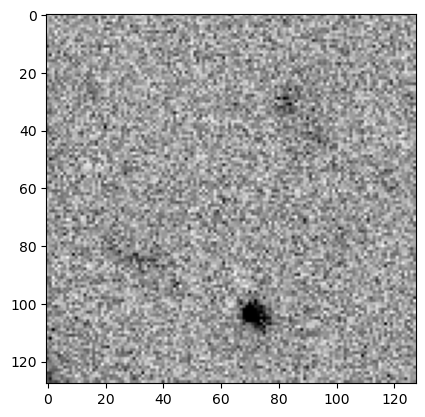

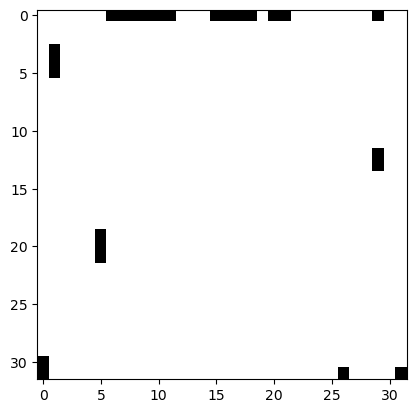

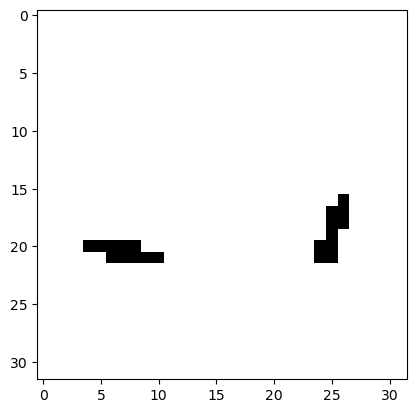

In [162]:
i = np.argwhere(y==1)[300,0]
plt.imshow(x[i, 0], cmap="Grays")
plt.show()
plt.imshow(p.numpy()[i, 0], cmap="Grays")
plt.show()
plt.imshow(y_d[i, 0], cmap="Grays")

(5000, 1, 128, 128) 7381.175362710643
(5000, 1, 32, 32) 2960.2492770387507


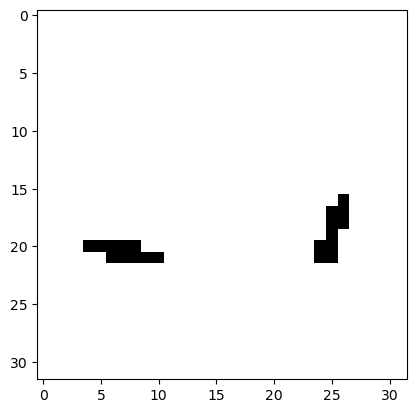

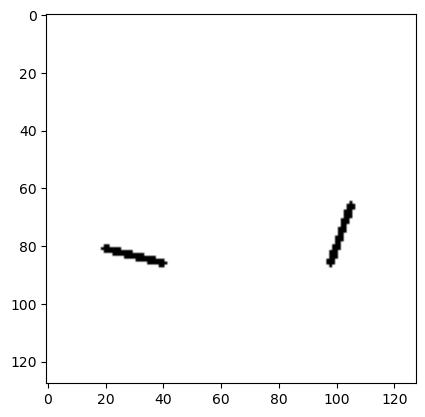

In [138]:
import numpy as np
#take first example from val dataset
with h5py.File("val.h5", "r") as f:
    # f["x"] and f["y"] are h5py.Dataset objects
    x = f["x"][:]   # loads shape (15000, 1, H, W) into RAM
    y = f["y"][:]   # same shape for labels

a = np.sum(y==0)/np.sum(y==1)
print (y.shape, a)
shape_o = get_model_output_size(model)
y_d = downsize_y(torch.tensor(y), shape_o).numpy()
a = np.sum(y_d==0)/np.sum(y_d==1)
print (y_d.shape, a)
i = np.argwhere(y==1)[300,0]
plt.imshow(y_d[i, 0], cmap="Grays")
plt.show()
plt.imshow(y[i, 0], cmap="Grays")

In [7]:
down_filters = [32, 64,  128, 256, 512]
up_filters   = [512, 256, 128, 64, 32]
down_activations = ['relu', 'relu', 'relu', 'sigmoid', 'relu']
up_activations = ['relu', 'sigmoid', 'relu', 'relu', 'relu']

model = UNet(downfeatures= down_filters, upfeatures=up_filters, downactivation=down_activations, upactivation=up_activations)
loss = ComboLoss(pos_weight=500, bce_weight=0.5, dice_weight=0.5)
train_ds = H5Dataset('train.h5')
val_ds   = H5Dataset('val.h5')
train(model, train_ds, val_ds, loss=loss, epochs=100)

Epoch 1:  26%|██▌       | 61/235 [00:03<00:09, 17.65it/s, avg_train_loss=0.02, batch_loss=0.0212, lr=4.02e-6]  Exception in thread Thread-10 (_pin_memory_loop):
Traceback (most recent call last):
  File "/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/home/karlo/miniconda3/envs/Asteroid_detection_CNN/lib/python3.12/site-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get

KeyboardInterrupt: 